In [1]:
%matplotlib widget

import sys
import os
from pathlib import Path

SCRIPT_DIR = Path(os.getcwd()).parent
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [2]:
import numpy as np

from python.fluorophores import FlStatic
from python.psfs import PsfVectorial
from python.estimators import est_quad1Diter
from python.estimators import est_quad2Diter
from python.simulators import Simulator
from python.tools import imx
# from python.mProfile import mProfile
# import cProfile, pstats, io
# from pstats import SortKey

In [3]:
fl = FlStatic(brightness=1000)  # define a static fluorophore
fl.pos = [10, 0, 0]

psf_vec = PsfVectorial() 
psf_vec.zerooffset=0.000  # True zero

sim = Simulator(fluorophores=fl)

numberOfLocalizations=1000

In [4]:
# define scan pattern
L = 75  # size of scan pattern
orbitpoints = 6  # number of probing points in orbit
probecenter = True  # should we also probe the center?
laserpower = 5  # relative, increases brightness
pointdwelltime = 0.1  # ms, measurement time in each point
repetitions = 2 # how often to repeat the pattern scan

# pr = cProfile.Profile()
# pr.enable()

sim.definePattern("donut", psf_vec, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.TIME
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

vortex0, 

In [5]:
# we need an estimator. Define as component
sim.defineComponent("estdonut", "estimator", est_quad2Diter, parameters=[L, probecenter], dim=(0,1))

In [6]:
seq = ["donut", "estdonut"]
# mProfile.profileOn(['psf_vectorial.py', 'effField.py', 'field.py', 'effIntensity.py'])

out = sim.runSequence(seq, maxlocs=numberOfLocalizations)


# out.loc: localizations
# out.fluorophores: position of fluorophores
# out.raw: photon measurements
sigmaCRB=sim.calculateCRBpattern("donut", dim=(0,1))/np.sqrt(np.mean(out.loc.phot))

print("vectorial PSF:")
sim.summarize_results(out)

psf0, _ = psf_vec.imagestack("vortex")

# mProfile.profileOff()
# mProfile.report()

vectorial PSF:
[[14. 23. 52. ... 40. 28.  2.]
 [17. 15. 31. ... 33. 21.  2.]
 [21. 19. 38. ... 36. 17.  1.]
 ...
 [12. 30. 34. ... 37. 26.  1.]
 [18. 30. 26. ... 48. 21.  2.]
 [17. 31. 37. ... 38. 30.  2.]]
photch: 15.4, 23.1, 38.5, 44.9, 38.1, 23.2, 2.1 mean(phot): 185.3   photon rate: 264.7 duration ms: 1400.0
std:  2.24, 2.09, 0.00 rmse: 2.25, 2.09, 0.00 pos: 9.88, -0.04, 0.00 bias: -0.12, -0.04, 0.00
locp: 1.95, 1.95, 0.00 sCRB: 1.92, 2.10, 0.00 sCRB*sqrt(phot): 26.1, 28.6, 0.0


## Pinhole
We simulate a pinhole in the detection channel.

In [7]:
psf_vecph = PsfVectorial()
psf_vecph.setpinhole(AU=1)

pinhole63300, 

In [8]:
sim.definePattern("donut_ph", psf_vecph, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

vortex0, 

In [9]:
seq = ["donut_ph", "estdonut"]
print("pinhole:")
out=sim.runSequence(seq)
sim.summarize_results(out)

psfph, _ = psf_vecph.imagestack("vortex")

pinhole:
[[15. 18. 27. ... 26. 22.  2.]
 [15. 17. 37. ... 29. 15.  1.]
 [18. 18. 34. ... 42. 23.  2.]
 ...
 [15. 16. 35. ... 24. 18.  0.]
 [14. 17. 27. ... 23. 20.  1.]
 [11. 15. 23. ... 36. 25.  1.]]
photch: 12.9, 19.4, 31.3, 37.7, 31.8, 19.5, 1.8 mean(phot): 154.4   photon rate: 220.6 duration ms: 1400.0
std:  2.54, 2.33, 0.00 rmse: 2.55, 2.33, 0.00 pos: 9.80, 0.13, 0.00 bias: -0.20, 0.13, 0.00
locp: 2.13, 2.13, 0.00 sCRB: 2.10, 2.30, 0.00 sCRB*sqrt(phot): 26.1, 28.6, 0.0


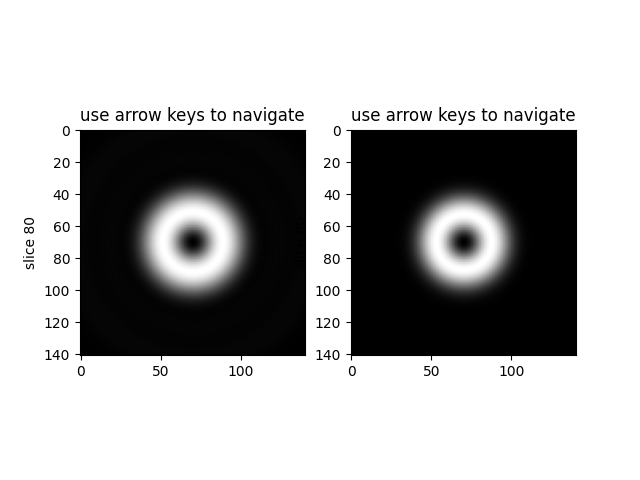

(<Figure size 640x480 with 2 Axes>,
  <python.tools.imx.IndexTracker at 0x115f7d210>])

In [10]:
imx([psf0, psfph])

## Misaligned pinhole
Now, lets move the pinhole (misalignment).

In [11]:
psf_vecph2 = PsfVectorial()
psf_vecph2.setpinhole(AU=1, offset=[150, 0])

pinhole6331500, 

In [12]:
sim.definePattern("donut_ph", psf_vecph2, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

vortex0, 

In [13]:
seq = ["donut_ph", "estdonut"]
print("pinhole misaligned:")
out=sim.runSequence(seq)
sim.summarize_results(out)

pinhole misaligned:
[[10. 20. 35. ... 27. 22.  1.]
 [ 6. 19. 39. ... 29. 20.  2.]
 [11. 15. 28. ... 34. 19.  0.]
 ...
 [11. 16. 36. ... 37. 20.  1.]
 [ 8. 13. 34. ... 35. 15.  3.]
 [10. 17. 33. ... 25. 18.  1.]]
photch: 12.9, 19.5, 31.7, 37.9, 32.0, 19.5, 1.9 mean(phot): 155.3   photon rate: 221.8 duration ms: 1400.0
std:  2.51, 2.40, 0.00 rmse: 2.51, 2.40, 0.00 pos: 9.91, 0.06, 0.00 bias: -0.09, 0.06, 0.00
locp: 2.13, 2.13, 0.00 sCRB: 2.09, 2.30, 0.00 sCRB*sqrt(phot): 26.1, 28.6, 0.0


Summary(photch=array([12.87287287, 19.47247247, 31.70770771, 37.85185185, 31.97297297,
       19.50550551,  1.86686687]), bg_photons_gt=np.float64(0.0), bg_photons_est=np.float64(0.0), phot=np.float64(155.25025025025025), phot_signal=np.float64(155.25025025025025), pos=array([9.91169655, 0.06015685, 0.        ]), std=array([2.50545072, 2.39691854, 0.        ]), rmse=array([2.50700635, 2.39767331, 0.        ]), bias=array([-0.08830345,  0.06015685,  0.        ]), locp=array([2.12813961, 2.12813961, 0.        ]), sCRB=array([2.09444604, 2.29695914, 0.        ]), sCRB1=array([26.09668419, 28.61998646,  0.        ]), duration=array([1400.]), stdraw=array([2.50545072, 2.39691854, 0.        ]), efo=None, photrate=np.float64(221.7860717860718))

In [14]:
# psfph2, _ = psf_vecph2.imagestack("vortex")
# imx([psf0, psfph2])

## Aberrations
Let us change the PSF by adding aberrations. Note, in this case we have to define the pattern again to calculate the PSFs anew. Instead here, we create a second PSF object.

In [15]:
psf_vec2 = PsfVectorial()
psf_vec2.setpinhole(AU=1)

# Add Zernike:
# Zr(k,0): n, Zr(k,1): m, Zr(k,2): amplitude as fraction of wavelength
sys_aberr = {}
sys_aberr['Zr'] = np.zeros((2,3))
sys_aberr['Zr'][0,0], sys_aberr['Zr'][0,1], sys_aberr['Zr'][0,2] = 4, 0, 0.3  # spherical aberrations 
sys_aberr['Zr'][1,0], sys_aberr['Zr'][1,1], sys_aberr['Zr'][1,2] = 2, 2, 0.05  # astigmatism 
sys_aberr['maskshift'] = [0,0]
psf_vec2.setpar(**sys_aberr)

pinhole63300, 

In [16]:
sim.definePattern("donut_aber", psf_vec2, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=4,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

seq = ["donut_aber", "estdonut"]
out = sim.runSequence(seq)

print("aberrations:")
sim.summarize_results(out)

vortex0, aberrations:
[[ 5. 12. 18. 15.  2.]
 [ 4. 10. 18. 15.  0.]
 [ 4.  9. 11. 10.  3.]
 ...
 [ 7. 13. 11. 13.  0.]
 [ 3. 13. 13.  8.  1.]
 [ 5. 15. 12. 19.  1.]]
photch: 6.6, 12.0, 17.5, 13.6, 1.5 mean(phot): 51.4   photon rate: 102.7 duration ms: 1000.0
std:  4.58, 4.34, 0.00 rmse: 4.66, 4.54, 0.00 pos: 9.14, 1.31, 0.00 bias: -0.86, 1.31, 0.00
locp: 3.70, 3.70, 0.00 sCRB: 4.22, 4.50, 0.00 sCRB*sqrt(phot): 30.2, 32.2, 0.0


Summary(photch=array([ 6.63963964, 12.03303303, 17.52552553, 13.60860861,  1.54954955]), bg_photons_gt=np.float64(0.0), bg_photons_est=np.float64(0.0), phot=np.float64(51.35635635635636), phot_signal=np.float64(51.35635635635636), pos=array([9.14417671, 1.31277101, 0.        ]), std=array([4.5770453 , 4.34268067, 0.        ]), rmse=array([4.65636953, 4.53676571, 0.        ]), bias=array([-0.85582329,  1.31277101,  0.        ]), locp=array([3.70014862, 3.70014862, 0.        ]), sCRB=array([4.2209576 , 4.49707402, 0.        ]), sCRB1=array([30.24879593, 32.22753864,  0.        ]), duration=array([1000.]), stdraw=array([4.5770453 , 4.34268067, 0.        ]), efo=None, photrate=np.float64(102.71271271271272))

In [17]:
# uncomment to show PSF:
# psfab, _ = psf_vec2.imagestack("vortex")
# imx([psf0, psfab])

## Misaligned phase plate

In [18]:
# psf_vec2 = PsfVectorial()
psf_vec2.setpinhole(AU=1)

# Add Zernike:
# Zr(k,0): n, Zr(k,1): m, Zr(k,2): amplitude as fraction of wavelength
sys_mis = {}
sys_mis['Zr'] = np.zeros((2,3))
sys_mis['Zr'][0,0], sys_mis['Zr'][0,1], sys_mis['Zr'][0,2] = 4, 0, 0.0  # spherical aberrations 
sys_mis['Zr'][1,0], sys_mis['Zr'][1,1], sys_mis['Zr'][1,2] = 2, 2, 0.0  # astigmatism 
sys_mis['maskshift'] = [0.2,0]
psf_vec2.setpar(**sys_mis)

pinhole63300, 

In [19]:
sim.definePattern("donut_misaligned", psf_vec2, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

seq = ["donut_misaligned", "estdonut"]
out = sim.runSequence(seq)

print("misaligned phase plate:")
sim.summarize_results(out)

vortex0, misaligned phase plate:
[[98. 73. 23. ... 16. 59. 19.]
 [68. 62. 21. ... 21. 56. 22.]
 [61. 49. 17. ... 28. 69. 10.]
 ...
 [66. 63. 28. ... 14. 55. 16.]
 [83. 67. 16. ... 18. 55. 13.]
 [81. 59. 24. ... 16. 70. 14.]]
photch: 80.4, 60.1, 19.9, 0.7, 19.6, 59.6, 17.6 mean(phot): 258.0   photon rate: 368.5 duration ms: 1400.0
std:  7.16, 3.31, 0.00 rmse: 45.26, 3.31, 0.00 pos: -34.69, -0.20, 0.00 bias: -44.69, -0.20, 0.00
locp: 1.65, 1.65, 0.00 sCRB: 3.18, 2.73, 0.00 sCRB*sqrt(phot): 51.1, 43.8, 0.0


Summary(photch=array([80.37737738, 60.05005005, 19.94794795,  0.67067067, 19.64264264,
       59.63263263, 17.63863864]), bg_photons_gt=np.float64(0.0), bg_photons_est=np.float64(0.0), phot=np.float64(257.95995995996), phot_signal=np.float64(257.95995995996), pos=array([-34.68892692,  -0.20220101,   0.        ]), std=array([7.15775634, 3.30777509, 0.        ]), rmse=array([45.25852036,  3.31394951,  0.        ]), bias=array([-44.68892692,  -0.20220101,   0.        ]), locp=array([1.65097356, 1.65097356, 0.        ]), sCRB=array([3.18051081, 2.72788521, 0.        ]), sCRB1=array([51.08260387, 43.81292431,  0.        ]), duration=array([1400.00000001]), stdraw=array([7.15775634, 3.30777509, 0.        ]), efo=None, photrate=np.float64(368.5142285142285))

In [20]:
# uncomment to show PSF:
# psfab, _ = psf_vec2.imagestack("vortex")
# imx([psf0, psfab])

## Zero offset
Now, let's add an offset to the PSF to make the minium non-zero.

In [21]:
psf_vec.zerooffset=0.005
out = sim.runSequence(seq)
print(f"zero offset = {psf_vec.zerooffset}:")
sim.summarize_results(out)

zero offset = 0.005:
[[76. 55. 15. ... 17. 51. 19.]
 [61. 73. 19. ... 24. 58. 12.]
 [86. 46. 23. ... 14. 77. 15.]
 ...
 [82. 62. 27. ... 16. 70. 12.]
 [74. 56. 17. ... 20. 57. 27.]
 [75. 50. 18. ... 25. 60. 16.]]
photch: 80.1, 59.8, 19.9, 0.7, 19.9, 59.5, 17.3 mean(phot): 257.2   photon rate: 367.5 duration ms: 1400.0
std:  7.18, 3.16, 0.00 rmse: 44.46, 3.16, 0.00 pos: -33.88, -0.10, 0.00 bias: -43.88, -0.10, 0.00
locp: 1.65, 1.65, 0.00 sCRB: 3.18, 2.73, 0.00 sCRB*sqrt(phot): 51.1, 43.8, 0.0


Summary(photch=array([80.12212212, 59.81081081, 19.93493493,  0.67867868, 19.90990991,
       59.51451451, 17.26726727]), bg_photons_gt=np.float64(0.0), bg_photons_est=np.float64(0.0), phot=np.float64(257.23823823823824), phot_signal=np.float64(257.23823823823824), pos=array([-33.87972384,  -0.09883937,   0.        ]), std=array([7.17688613, 3.1605171 , 0.        ]), rmse=array([44.46276936,  3.16206223,  0.        ]), bias=array([-43.87972384,  -0.09883937,   0.        ]), locp=array([1.65328797, 1.65328797, 0.        ]), sCRB=array([3.18496939, 2.73170928, 0.        ]), sCRB1=array([51.08260387, 43.81292431,  0.        ]), duration=array([1400.00000001]), stdraw=array([7.17688613, 3.1605171 , 0.        ]), efo=None, photrate=np.float64(367.48319748319744))

## Bead size

In [22]:
psf_vec2.setpinhole(AU=1)

# Add Zernike:
# Zr(k,0): n, Zr(k,1): m, Zr(k,2): amplitude as fraction of wavelength
sys_b = {}
sys_b['Zr'] = np.zeros((2,3))
sys_b['Zr'][0,0], sys_b['Zr'][0,1], sys_b['Zr'][0,2] = 4, 0, 0.0  # spherical aberrations 
sys_b['Zr'][1,0], sys_b['Zr'][1,1], sys_b['Zr'][1,2] = 2, 2, 0.0  # astigmatism 
sys_b['maskshift'] = [0.0,0]
sys_b['beadradius'] = 50e-9  # 100 nm beads
psf_vec2.setpar(**sys_b)

pinhole63300, 

In [23]:
sim.definePattern("donut_bead", psf_vec2, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions)

seq = ["donut_bead", "estdonut"]
out = sim.runSequence(seq)

print("bead size:")
sim.summarize_results(out)

vortex0, bead size:
[[24. 39. 56. ... 47. 31. 17.]
 [31. 38. 41. ... 50. 39. 13.]
 [25. 38. 40. ... 44. 32. 20.]
 ...
 [36. 40. 36. ... 41. 38. 25.]
 [26. 32. 49. ... 41. 34. 23.]
 [36. 28. 46. ... 45. 33. 14.]]
photch: 28.2, 33.9, 44.9, 50.3, 45.1, 33.9, 17.7 mean(phot): 254.0   photon rate: 362.9 duration ms: 1400.0
std:  1.82, 1.84, 0.00 rmse: 4.81, 1.84, 0.00 pos: 5.54, 0.03, 0.00 bias: -4.46, 0.03, 0.00
locp: 1.66, 1.66, 0.00 sCRB: 3.40, 3.23, 0.00 sCRB*sqrt(phot): 54.1, 51.5, 0.0


Summary(photch=array([28.15215215, 33.93293293, 44.86586587, 50.33233233, 45.12512513,
       33.85485485, 17.73273273]), bg_photons_gt=np.float64(0.0), bg_photons_est=np.float64(0.0), phot=np.float64(253.995995995996), phot_signal=np.float64(253.995995995996), pos=array([5.54168927, 0.03089028, 0.        ]), std=array([1.81855011, 1.83695304, 0.        ]), rmse=array([4.81494123, 1.83721274, 0.        ]), bias=array([-4.45831073,  0.03089028,  0.        ]), locp=array([1.66380657, 1.66380657, 0.        ]), sCRB=array([3.3950024 , 3.23242535, 0.        ]), sCRB1=array([54.10700817, 51.51597686,  0.        ]), duration=array([1400.00000001]), stdraw=array([1.81855011, 1.83695304, 0.        ]), efo=None, photrate=np.float64(362.85142285142285))

## 3D with tophat

In [ ]:
sim.fluorophores.pos = [10, 0, 20]
psf_vecth = PsfVectorial()
psf_vecth.setpinhole("AU",1)

orbitpoints = 4
probecenterxy = True
probecenterz = True
L = 75
Lz = 150

laserpower = 30

pinhole63300, 

In [ ]:
sim.definePattern("tophat_xy", psf_vecth, 
                  phasemask="tophat",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenterxy, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions,
                  dim=(0,1))

sim.definePattern("tophat_z", psf_vecth, 
                  phasemask="tophat",
                  makepattern="zscan", 
                  orbitpoints=2,
                  probecenter=probecenterz, 
                  orbitL=Lz, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions,
                  dim=(2,))

In [ ]:
sim.defineComponent("esttophat_xy", "estimator", est_quad2Diter, parameters=[L, probecenter], dim=(0,1))
sim.defineComponent("esttophat_z", "estimator", est_quad1Diter, parameters=[Lz], dim=(2,))

In [ ]:
seq = ["tophat_xy", "esttophat_xy", "tophat_z", "esttophat_z"]
out=sim.runSequence(seq)

print("3D with tophat:")
sim.summarize_results(out)

## 3D with tophat and vortex

In [ ]:
laserpower=5
sim.definePattern("donut_xy", psf_vecth, 
                  phasemask="vortex",
                  makepattern="orbitscan", 
                  orbitpoints=orbitpoints,
                  probecenter=probecenter, 
                  orbitL=L, 
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions,
                  dim=(0,1))

In [ ]:
seq = ["donut_xy", "estdonut", "tophat_z", "esttophat_z"]
out=sim.runSequence(seq)

print("3D with donut and tophat:")
sim.summarize_results(out)

## PhaseFlux 3D localization

In [ ]:
sim.fluorophores.pos = [0, 0, 0]
psf_vecphaseflux = PsfVectorial()
psf_vecphaseflux.setpinhole("AU",1)

L = 75
Lz = 150
fwhm = 450
sigmaz = 200
laserpower = 5
laserpowerz = 30
zeroposx = np.atleast_2d(np.array([-1,1,0])*L/2)
zeroposz = np.atleast_2d(np.array([-1,1,0])*Lz/2)

In [ ]:
sim.definePattern("pf_x", psf_vecphaseflux, 
                  phasemask="halfmoonx",
                  zeropos = zeroposx,
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions,
                  dim=(0,))

sim.definePattern("pf_y", psf_vecphaseflux, 
                  phasemask="halfmoony",
                  zeropos = zeroposx,
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpower, 
                  repetitions=repetitions,
                  dim=(1,))

sim.definePattern("pf_z", psf_vecphaseflux, 
                  phasemask="tophat",
                  zeropos = zeroposz,
                  pointdwelltime=pointdwelltime, 
                  laserpower=laserpowerz, 
                  repetitions=repetitions,
                  dim=(2,))

In [ ]:
sim.defineComponent("est_x", "estimator", est_quad1Diter, parameters=[L], dim=(0,))
sim.defineComponent("est_y", "estimator", est_quad1Diter, parameters=[L], dim=(1,))
sim.defineComponent("est_z", "estimator", est_quad1Diter, parameters=[Lz], dim=(2,))

In [ ]:
seq = ["pf_x", "est_x", "pf_y", "est_y", "pf_z", "est_z"]
out=sim.runSequence(seq)
print("PhaseFLUX:")
sim.summarize_results(out)